In [1]:
import xarray as xr
import rioxarray as rioxr

import geopandas as geopd
import pandas as pd

import numpy as np

import os

import glob

import time

#from shapely.geometry import Polygon

from multiprocessing import Pool

from tqdm.notebook import tqdm

#from parallelbar import progress_map

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300

In [2]:
vector_watershed_path = "CAMELS-FI catchments/CAMELS-FI_catchments.gpkg"
watersheds = geopd.read_file(vector_watershed_path, layer='v1')
"""
watersheds = watersheds.explode()
watersheds['area'] = watersheds.area
watersheds = watersheds[watersheds['area'] > 1500]
watersheds.reset_index(drop=True)
"""
# reprojecting to WGS84 to allow for no need to reproject within loop
watersheds = watersheds.to_crs(epsg=4326)


In [5]:
def swe_catchment_mean(args):
    file, watersheds = args
    swe = pd.DataFrame(columns=watersheds.Paikka_Id, index=pd.to_datetime([]))
    swe.index.name = 'date'
    
    with xr.open_dataset(file, mask_and_scale=True, decode_coords='all') as dataset:
        # Comment out when running for long
        #dataset = src.copy()
        # We only need the product, not the uncertainty
        data_array = dataset['swe']
        #data_array = data_array.drop_vars('time')
        # Clipping roughly to Finland to reduce interpolation time
        time = pd.to_datetime(data_array.time.item())
        data_array = data_array.loc[:, 59:71, 20:32]
        # Negative areas mark areas such as waters, glaciers, nodata etc. this causes gaps in large lakes of Finland that need to be interpolated
        data_array = xr.where(data_array < 0, np.nan, data_array)
        # Due to pixel size. more interpolation is given longitudinally. East-West is generally a bit more similar so it goes first
        data_array = data_array.interpolate_na('lon', limit=3, max_gap=1)
        data_array = data_array.interpolate_na('lat', limit=2, max_gap=1)
        data_array = data_array.rio.write_crs("epsg:4326")
        data_array = data_array.rename(lon='longitude', lat='latitude')
        swe_list = []
        for i in range(len(watersheds)):
            watershed = watersheds.loc[[i]]
            
            mean_swe = data_array.rio.clip(watershed.geometry.values, crs=watershed.crs, all_touched=True).mean().item()
            swe_list.append(round(mean_swe, 2))
    swe.loc[time] = swe_list
    return swe

In [6]:
root = "/media/iielse/T9/finland_climate/snow/data/swe/MERGED/v3.1"
glob_root = root + '/**/**/*.nc'
# set because glob produces duplicates
files = {file for file in glob.iglob(glob_root, recursive=True)}
files = list(files)
assert len(files) > 0, f"no files found with glob {glob_root}, check path"



counter = 0
#pbar = tqdm(files)
# Avoiding opening the same file multiple times by doing all the same operations with same file open. set because glob produces duplicates
arg_list = []
for file in files:
    #if counter < 25100 or counter > 25220:
        #counter += 1
        #continue
    counter += 1
    arg_list.append((file, watersheds))

# Because of a memory leak, these need to be divided into chunks
chunks = []
chunk_size = 108
for i in range(0, len(arg_list), chunk_size):
    chunks.append(arg_list[i:i + chunk_size])

In [7]:
len(arg_list)

8963

In [8]:
swe_list = []
for chunk in tqdm(chunks):
    with Pool(18) as p:
        swe_list.append(p.map(swe_catchment_mean, chunk))
#swe_list = progress_map(swe_catchment_mean, arg_list)

swe_list_flat = []
# Combining all the lists into one big one
for chunk in swe_list:
    swe_list_flat.extend(chunk)

swe = pd.concat(swe_list_flat)
swe = swe.sort_index()
swe.to_csv("/media/iielse/T9/CAMELS-FI/data/timeseries_by_attribute/swe.csv")

  0%|          | 0/83 [00:00<?, ?it/s]

In [72]:
swe

Paikka_Id,996,1003,1008,1009,1012,1014,1015,1018,1019,1021,...,937,941,943,946,951,961,964,1369,1366,1357
date,,,,,,,,,,,,,,,,,,,,,
1979-01-02,40.46,22.44,10.46,10.00,9.02,2.37,21.17,20.49,11.86,0.00,...,49.88,58.25,57.71,55.48,52.72,30.55,0.00,0.00,0.00,0.00
1979-01-04,38.18,35.63,16.54,15.86,14.36,4.84,23.29,22.90,13.36,0.00,...,51.03,59.12,57.41,54.60,52.33,35.59,0.00,70.31,79.71,60.21
1979-01-06,45.13,32.73,15.10,14.48,13.11,4.21,26.35,25.85,25.64,1.57,...,53.41,77.12,74.03,66.00,64.28,41.71,0.00,60.23,71.86,63.61
1979-01-08,50.46,40.55,21.67,20.80,19.08,11.47,31.20,30.87,41.21,1.86,...,61.70,68.67,67.71,65.75,64.25,50.18,0.32,62.00,63.81,53.27
1979-01-10,49.58,49.63,25.76,24.68,22.58,11.05,33.66,33.35,45.64,1.71,...,65.69,87.42,83.06,76.28,73.28,52.72,0.32,79.46,86.90,77.37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-26,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,8.45
2022-05-27,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2022-05-28,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


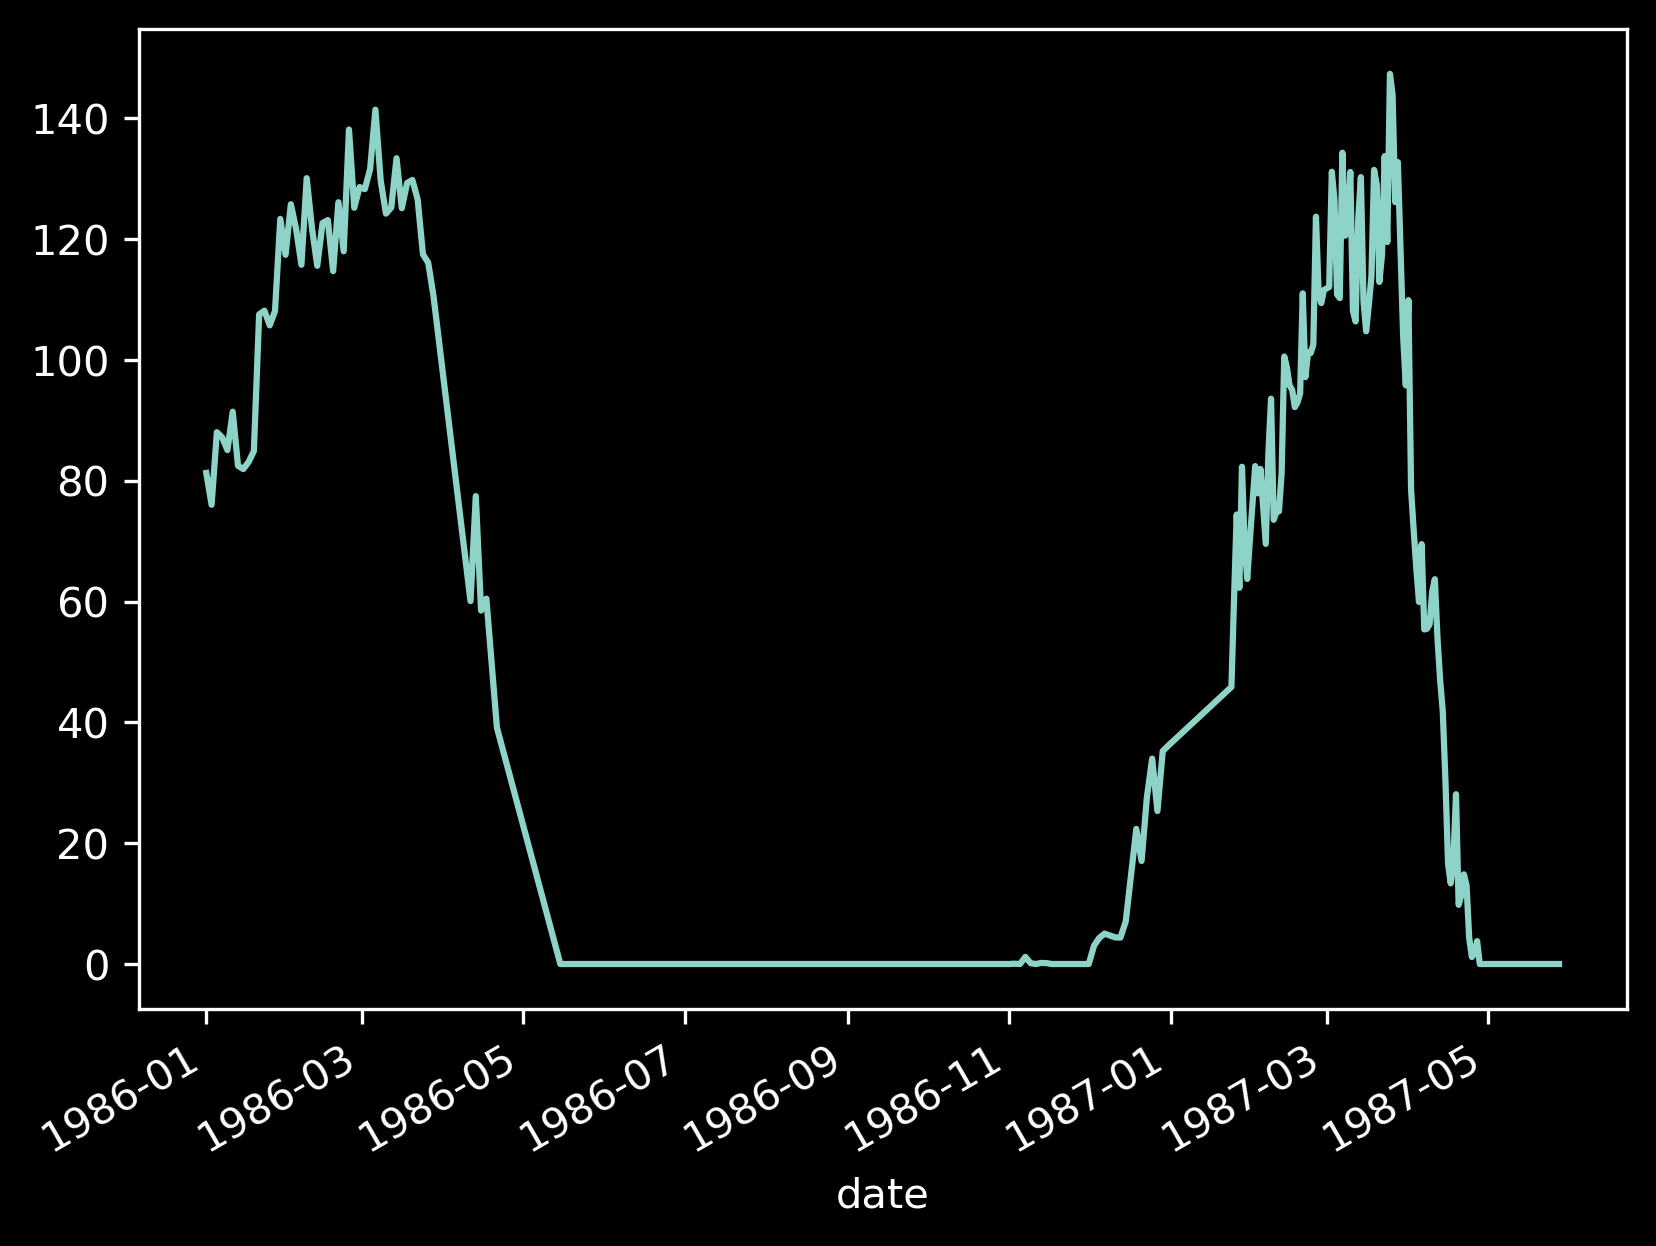

In [52]:
ax = swe.loc["1986":"1987-5", "996"].plot()

In [53]:
full_index = pd.date_range(start=swe.index.min(), 
                     end=swe.index.max(), freq='D')
actual_index = swe.index

diff_index = full_index.difference(actual_index)

In [60]:
actual_index

DatetimeIndex(['1979-01-02', '1979-01-02', '1979-01-02', '1979-01-04',
               '1979-01-04', '1979-01-04', '1979-01-06', '1979-01-06',
               '1979-01-06', '1979-01-08',
               ...
               '2022-05-27', '2022-05-28', '2022-05-28', '2022-05-28',
               '2022-05-29', '2022-05-29', '2022-05-29', '2022-05-30',
               '2022-05-30', '2022-05-30'],
              dtype='datetime64[ns]', name='date', length=26889, freq=None)

In [59]:
diff_index

DatetimeIndex(['1979-01-03', '1979-01-05', '1979-01-07', '1979-01-09',
               '1979-01-11', '1979-01-13', '1979-01-15', '1979-01-17',
               '1979-01-19', '1979-01-21',
               ...
               '2022-01-15', '2022-01-16', '2022-01-17', '2022-01-18',
               '2022-01-19', '2022-01-20', '2022-01-21', '2022-01-30',
               '2022-01-31', '2022-02-01'],
              dtype='datetime64[ns]', length=6892, freq=None)

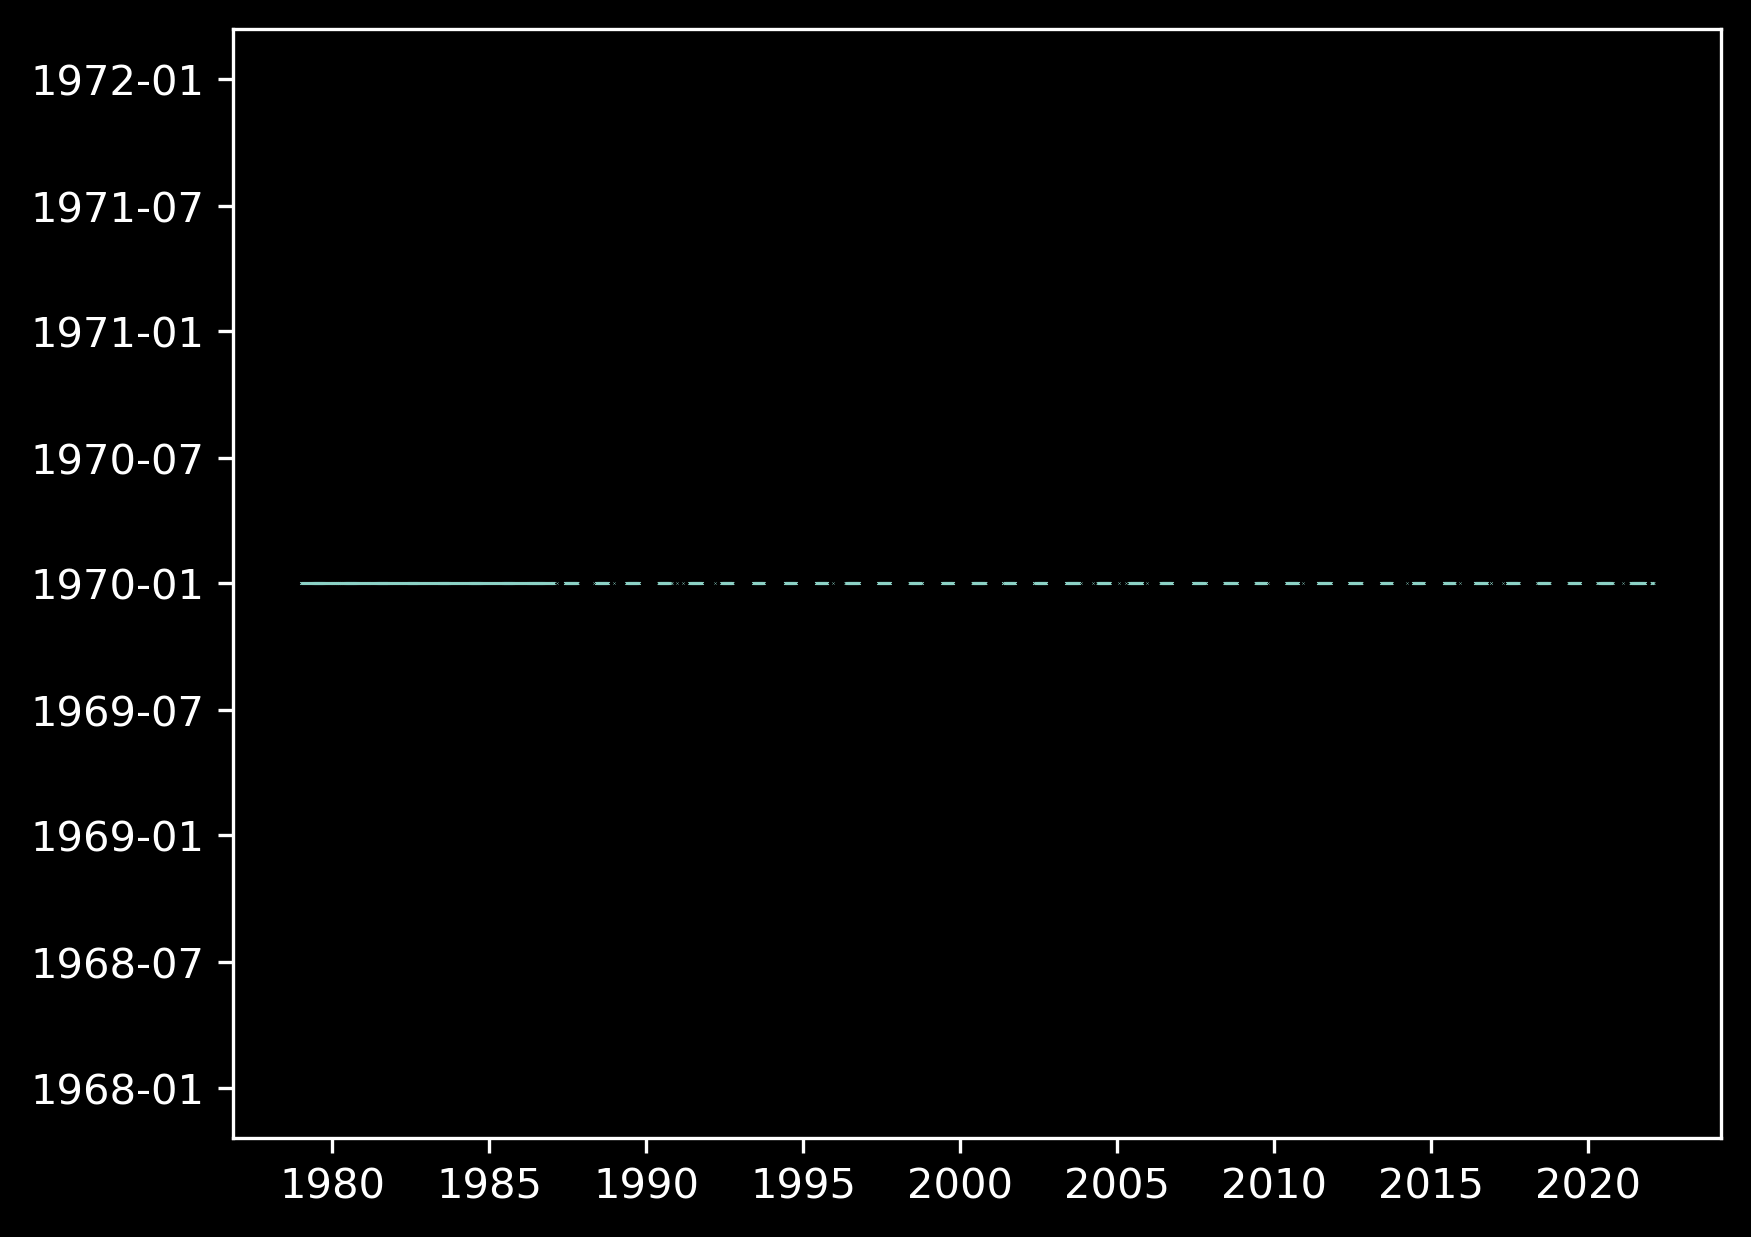

In [66]:
y_loc = 1 
ax = plt.plot(diff_index, np.zeros_like(diff_index) + y_loc, 'x', markersize=0.05)

In [120]:
swe.loc["2019-5"]

Paikka_Id,996,1003,1008,1009,1012,1014,1015,1018,1019,1021,...,937,941,943,946,951,961,964,1369,1366,1357
date,,,,,,,,,,,,,,,,,,,,,
2019-05-01,0.04,8.11,5.47,5.20,4.70,0.0,3.42,3.31,0.0,1.29,...,5.78,6.71,7.15,7.94,7.84,6.60,1.16,23.69,21.48,93.89
2019-05-02,0.01,3.24,1.51,1.43,1.30,0.0,1.37,1.33,0.0,0.71,...,2.69,4.29,3.18,2.72,3.74,1.95,0.00,22.62,17.57,98.29
2019-05-03,0.01,0.82,0.38,0.36,0.34,0.0,0.68,0.66,0.0,1.43,...,1.20,5.42,4.09,3.35,5.14,1.62,0.00,25.00,20.71,102.26
2019-05-04,0.00,2.89,1.24,1.18,1.06,0.0,1.59,1.54,0.0,2.29,...,2.61,13.21,10.24,7.43,8.25,1.89,0.00,34.00,26.67,99.93
2019-05-05,0.00,0.24,0.10,0.10,0.09,0.0,0.56,0.54,0.0,1.14,...,0.34,7.33,5.59,4.00,3.29,1.02,0.00,30.46,25.43,96.18
2019-05-06,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.71,...,0.16,1.79,1.26,0.66,0.42,0.62,0.00,20.85,20.10,95.01
2019-05-07,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.71,...,0.00,0.04,0.03,0.02,0.01,0.03,0.00,22.23,12.71,94.99
2019-05-08,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.71,...,0.00,0.25,0.18,0.09,0.06,0.10,0.00,21.46,12.10,115.34
2019-05-09,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,...,0.00,0.08,0.06,0.03,0.02,0.02,0.00,43.69,34.00,91.63


In [118]:
test.loc["2020-5"]

Paikka_Id,996,1003,1008,1009,1012,1014,1015,1018,1019,1021,...,937,941,943,946,951,961,964,1369,1366,1357
2020-05-01,0.000000,8.690,3.75,3.550,3.200,0.0,1.520000,1.470000,0.0,0.0,...,27.840,17.83,21.91,24.49,25.81,12.770,0.0,235.620000,251.100000,301.280000
2020-05-02,0.000000,6.420,2.77,2.620,2.360,0.0,1.130000,1.090000,0.0,0.0,...,19.430,10.42,13.76,16.60,18.25,9.390,0.0,230.230000,244.670000,300.320000
2020-05-03,0.000000,4.240,1.83,1.730,1.560,0.0,0.740000,0.720000,0.0,0.0,...,12.410,4.62,7.03,8.78,9.69,4.790,0.0,224.620000,237.140000,299.330000
2020-05-04,0.540000,1.710,0.74,0.700,0.630,0.0,0.410000,0.400000,0.0,0.0,...,4.940,0.42,1.24,1.97,2.58,1.490,0.0,211.690000,223.860000,296.010000
2020-05-05,0.000000,0.310,0.13,0.120,0.110,0.0,0.050000,0.050000,0.0,0.0,...,1.460,0.00,0.00,0.00,0.00,0.000,0.0,198.620000,209.480000,286.230000
2020-05-06,0.000000,0.000,0.00,0.000,0.000,0.0,0.000000,0.000000,0.0,0.0,...,0.300,0.00,0.00,0.00,0.06,0.000,0.0,182.310000,193.520000,276.120000
2020-05-07,0.000000,0.000,0.00,0.000,0.000,0.0,0.000000,0.000000,0.0,0.0,...,0.040,0.00,0.00,0.00,0.00,0.000,0.0,180.540000,190.620000,266.530000
2020-05-08,0.000000,0.000,0.00,0.000,0.000,0.0,0.000000,0.000000,0.0,0.0,...,0.120,0.00,0.00,0.00,0.04,0.000,0.0,173.000000,182.100000,259.700000
2020-05-09,0.000000,0.000,0.00,0.000,0.000,0.0,0.000000,0.000000,0.0,0.0,...,0.010,0.00,0.00,0.00,0.00,0.000,0.0,167.310000,176.190000,258.910000
2020-05-10,0.000000,0.000,0.00,0.000,0.000,0.0,0.000000,0.000000,0.0,0.0,...,0.010,0.00,0.00,0.00,0.00,0.000,0.0,171.620000,179.950000,265.460000


In [119]:
test['996'].isna().sum()

np.int64(5704)

In [80]:
test['996'].isna().sum()

np.int64(6892)

In [10]:
swe.to_csv("climate/swe.csv")

<Axes: xlabel='date'>

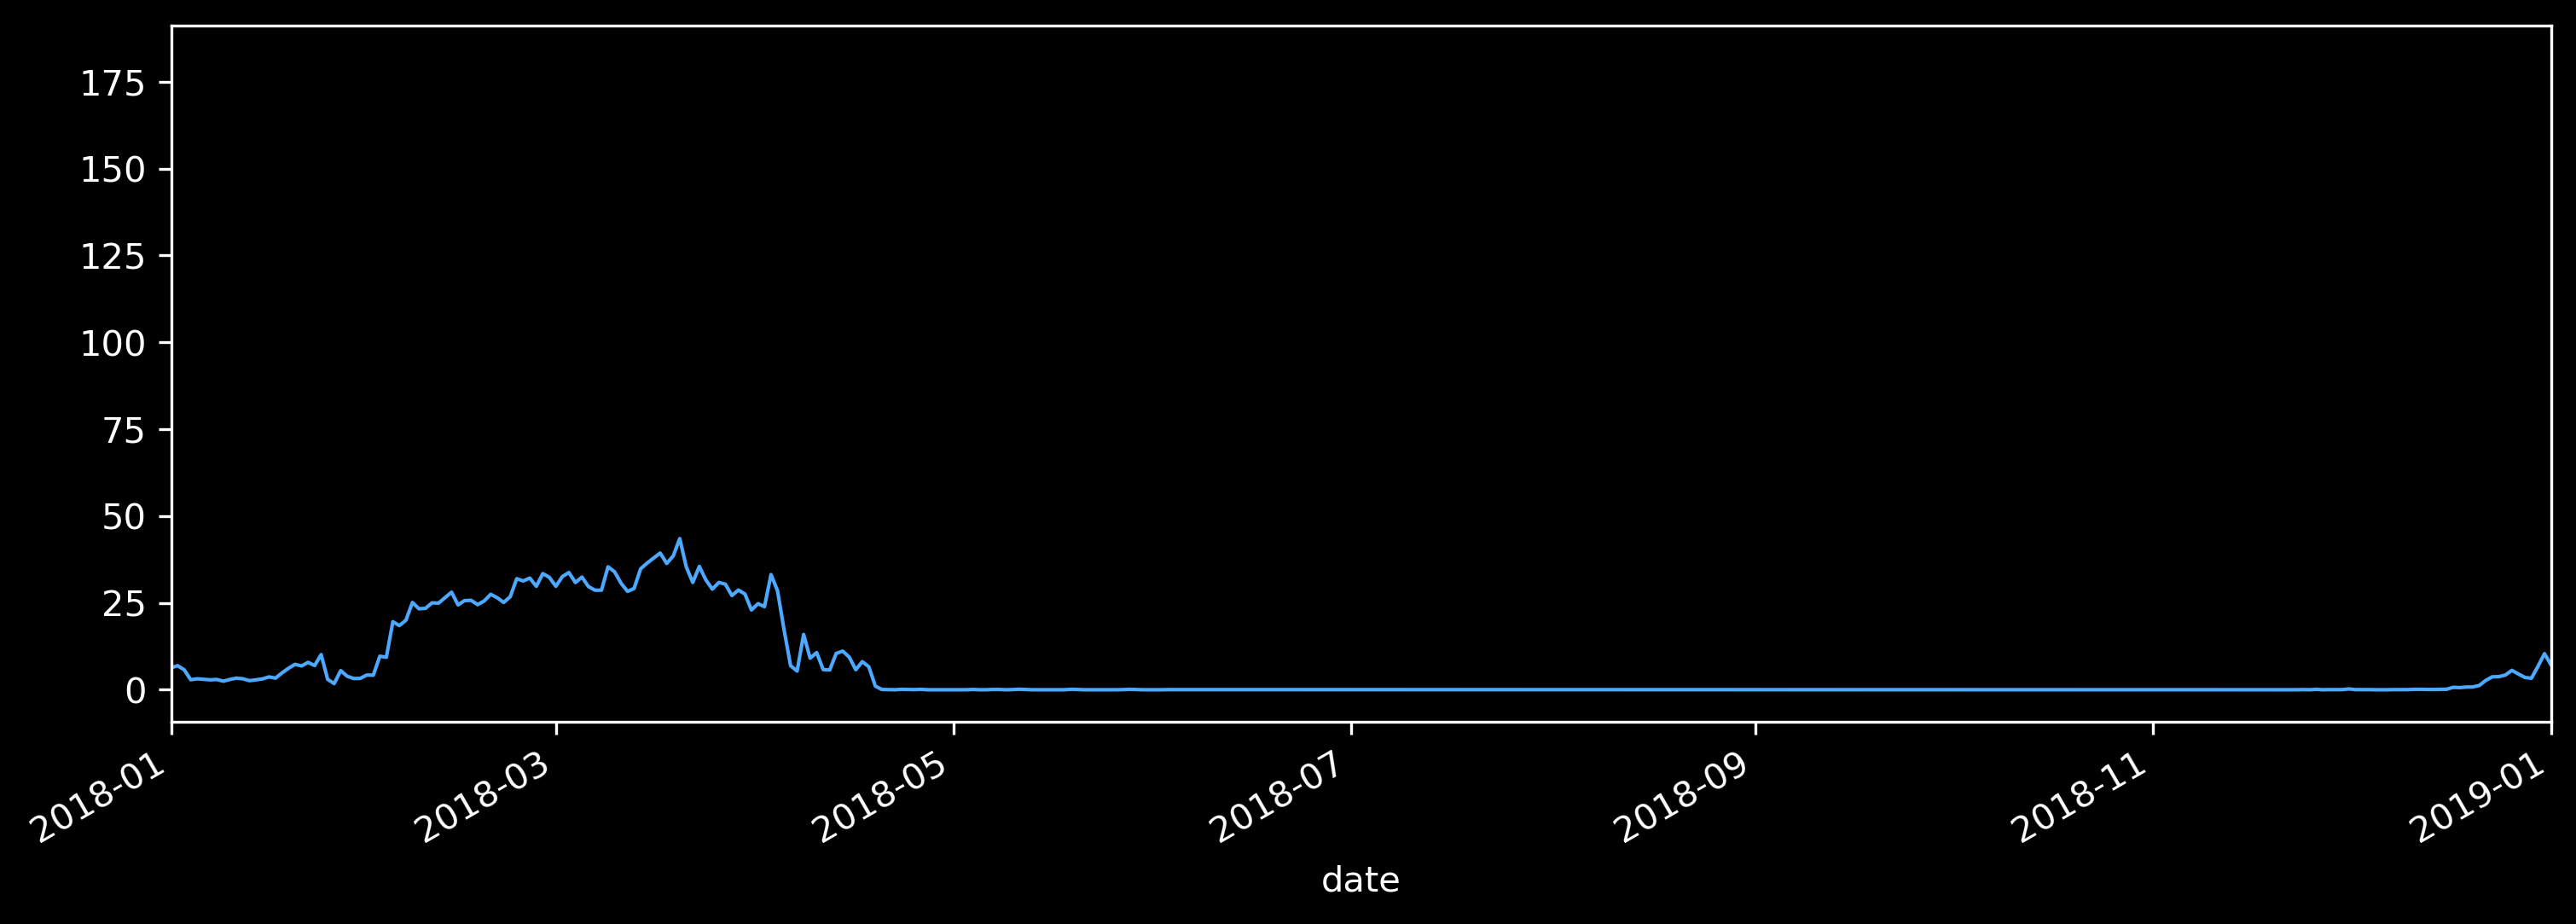

In [16]:
plt.style.use('dark_background')
color = '#4ca9ff'
swe[['1117']].plot.line(figsize=(12, 4), color=color, xlim=("2018","2019"), alpha=1, linewidth=1, legend=False)

In [39]:
root = "/media/iiro/T9/finland_climate/snow/data/swe/MERGED/v3.1"
glob_root = root + '/**/**/*.nc'
files = [file for file in glob.iglob(glob_root, recursive=True)]
assert len(files) > 0, f"no files found with glob {glob_root}, check path"
swe = pd.DataFrame(columns=watersheds.Paikka_Id, index=pd.to_datetime([]))
swe.index.name = 'date'


counter = 0
#pbar = tqdm(files)
# Avoiding opening the same file multiple times by doing all the ssame operations with same file open
for file in files:
    if counter != 25140:
        counter += 1
        continue
    with xr.open_dataset(file, mask_and_scale=True, decode_coords='all') as src:
        # Comment out when running for long
        #dataset = src.copy()
        # We only need the product, not the uncertainty
        data_array = src['swe']
        #data_array = data_array.drop_vars('time')
    # Clipping roughly to Finland to reduce interpolation time
    time = pd.to_datetime(data_array.time.item())
    data_array = data_array.loc[:, 59:71, 20:32]
    # Negative areas mark areas such as waters, glaciers, nodata etc. this causes gaps in large lakes of Finland that need to be interpolated
    data_array = xr.where(data_array < 0, np.nan, data_array)
    # Due to pixel size. more interpolation is given longitudinally. East-West is generally a bit more similar so it goes first
    data_array = data_array.interpolate_na('lon', limit=3, max_gap=1)
    data_array = data_array.interpolate_na('lat', limit=2, max_gap=1)
    data_array = data_array.rio.write_crs("epsg:4326")
    data_array = data_array.rename(lon='longitude', lat='latitude')
    swe_list = []
    for i in range(len(watersheds)):
        watershed = watersheds.loc[[i]]
        #watershed = watershed.explode()
        place_id = watershed.at[i, 'Paikka_Id']
        # Constructing the path of the timeseries for this catchmentparallel 
        
        #data_array = data_array.drop_vars('time')
        mean_swe = data_array.rio.clip(watershed.geometry.values, crs=watershed.crs, all_touched=True).mean().item()
        swe_list.append(round(mean_swe, 2))
    swe.loc[time] = swe_list
        
        
    break   

In [38]:
swe = pd.DataFrame(columns=watersheds.Paikka_Id, index=pd.to_datetime([]))
swe.index.name = 'date'
swe

Paikka_Id,896,905,907,930,931,933,958,969,976,1025,...,1293,1379,1390,1413,1414,1415,1427,2589,3009,3211
date,,,,,,,,,,,,,,,,,,,,,


In [17]:
print(swe.index.is_monotonic_increasing)
print(swe.index.is_unique)

False
False


KeyError: Index(['date'], dtype='object')

<Axes: >

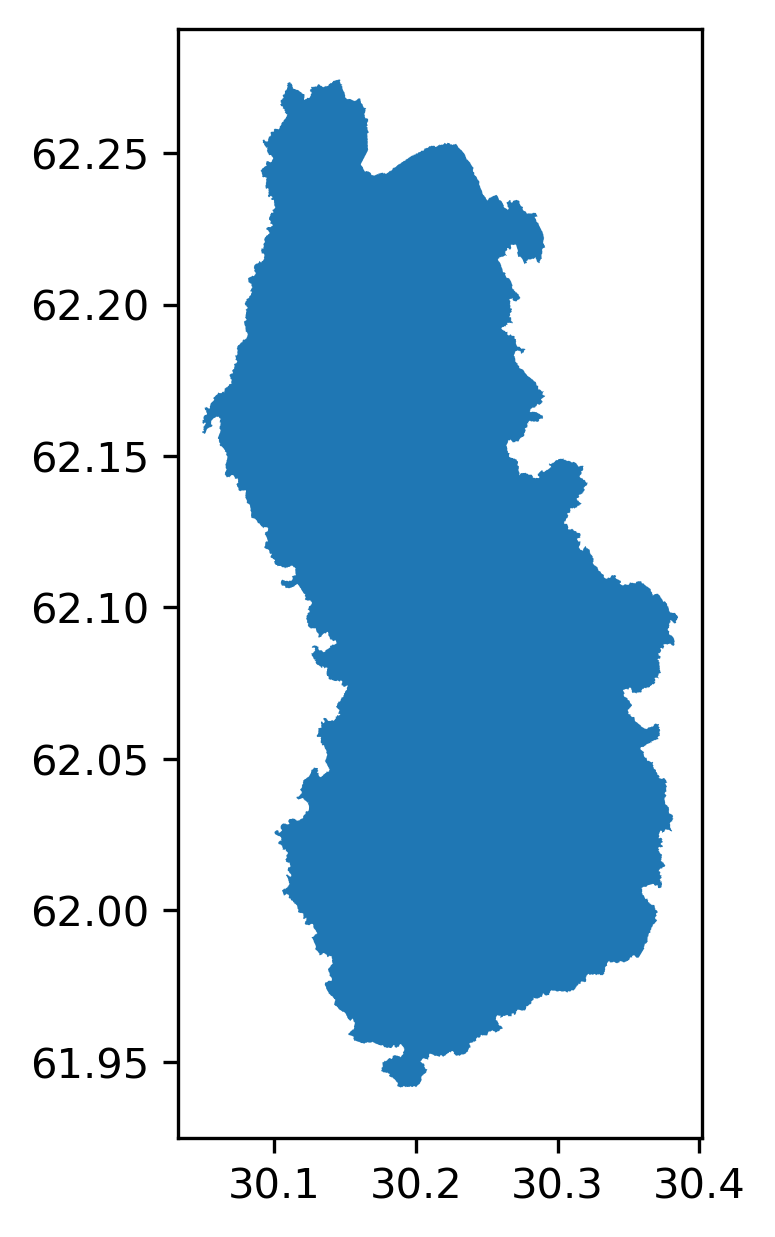

In [21]:
watershed.plot()

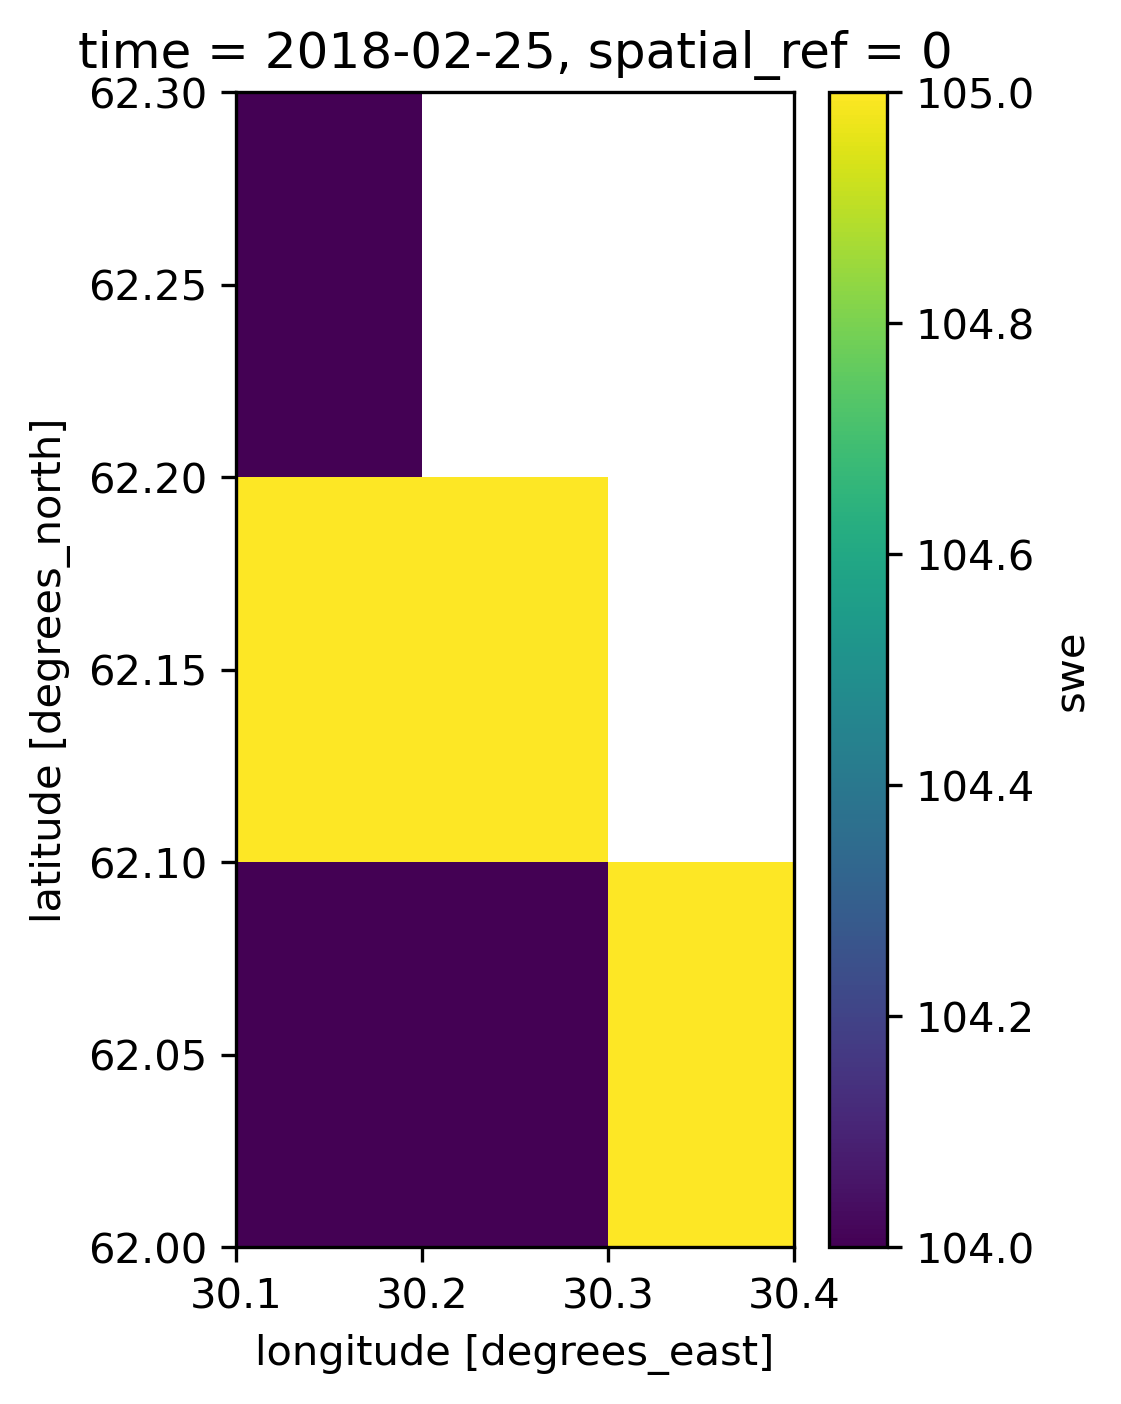

In [23]:
clipped_array.plot(aspect=0.6, size=5)

In [ ]:
finland_bbox = [
    {
        'type': 'Polygon',
        'coordinates': [[
            [20, 59],
            [32, 59],
            [32, 71],
            [20, 71]
        ]]
    }
]

In [11]:
aspect = 22/ 30
qm = data_array.plot(cmap='Blues', size=5, aspect=aspect, vmin=0, vmax=200)

TypeError: No numeric data to plot.

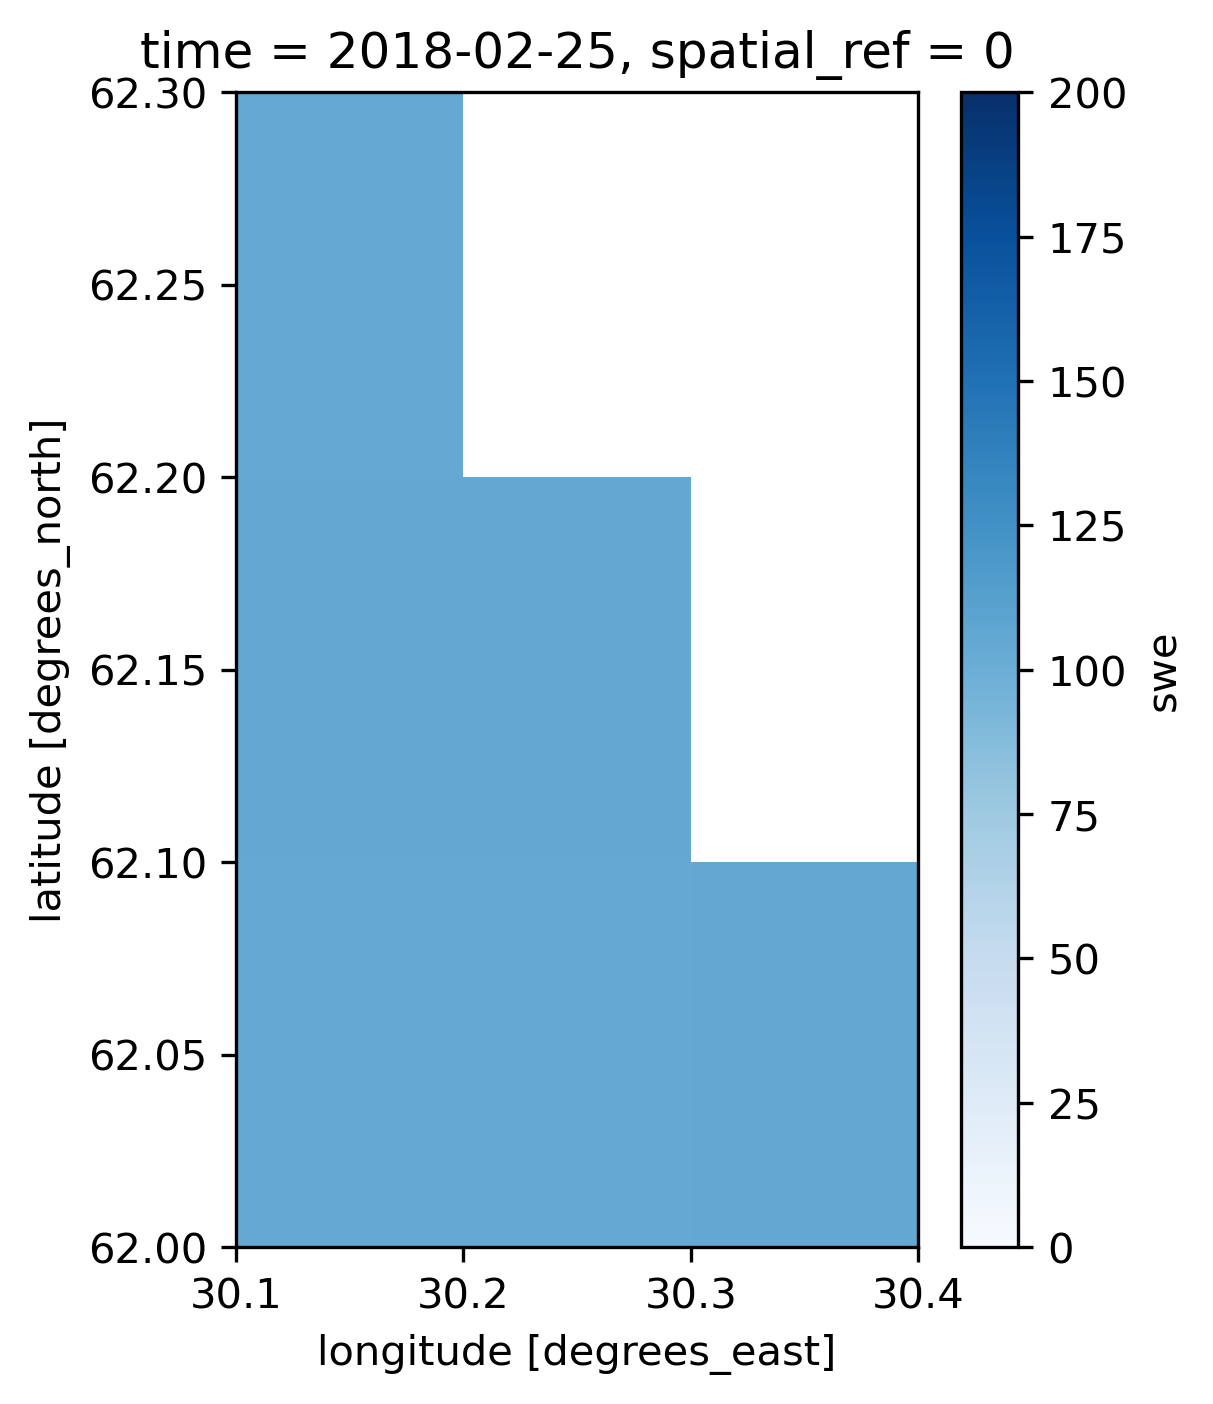

In [16]:
test = data_array.rio.clip(watershed.geometry.values, crs=watershed.crs)

qm = test.plot(cmap='Blues', size=5, aspect=aspect, vmin=0, vmax=200)

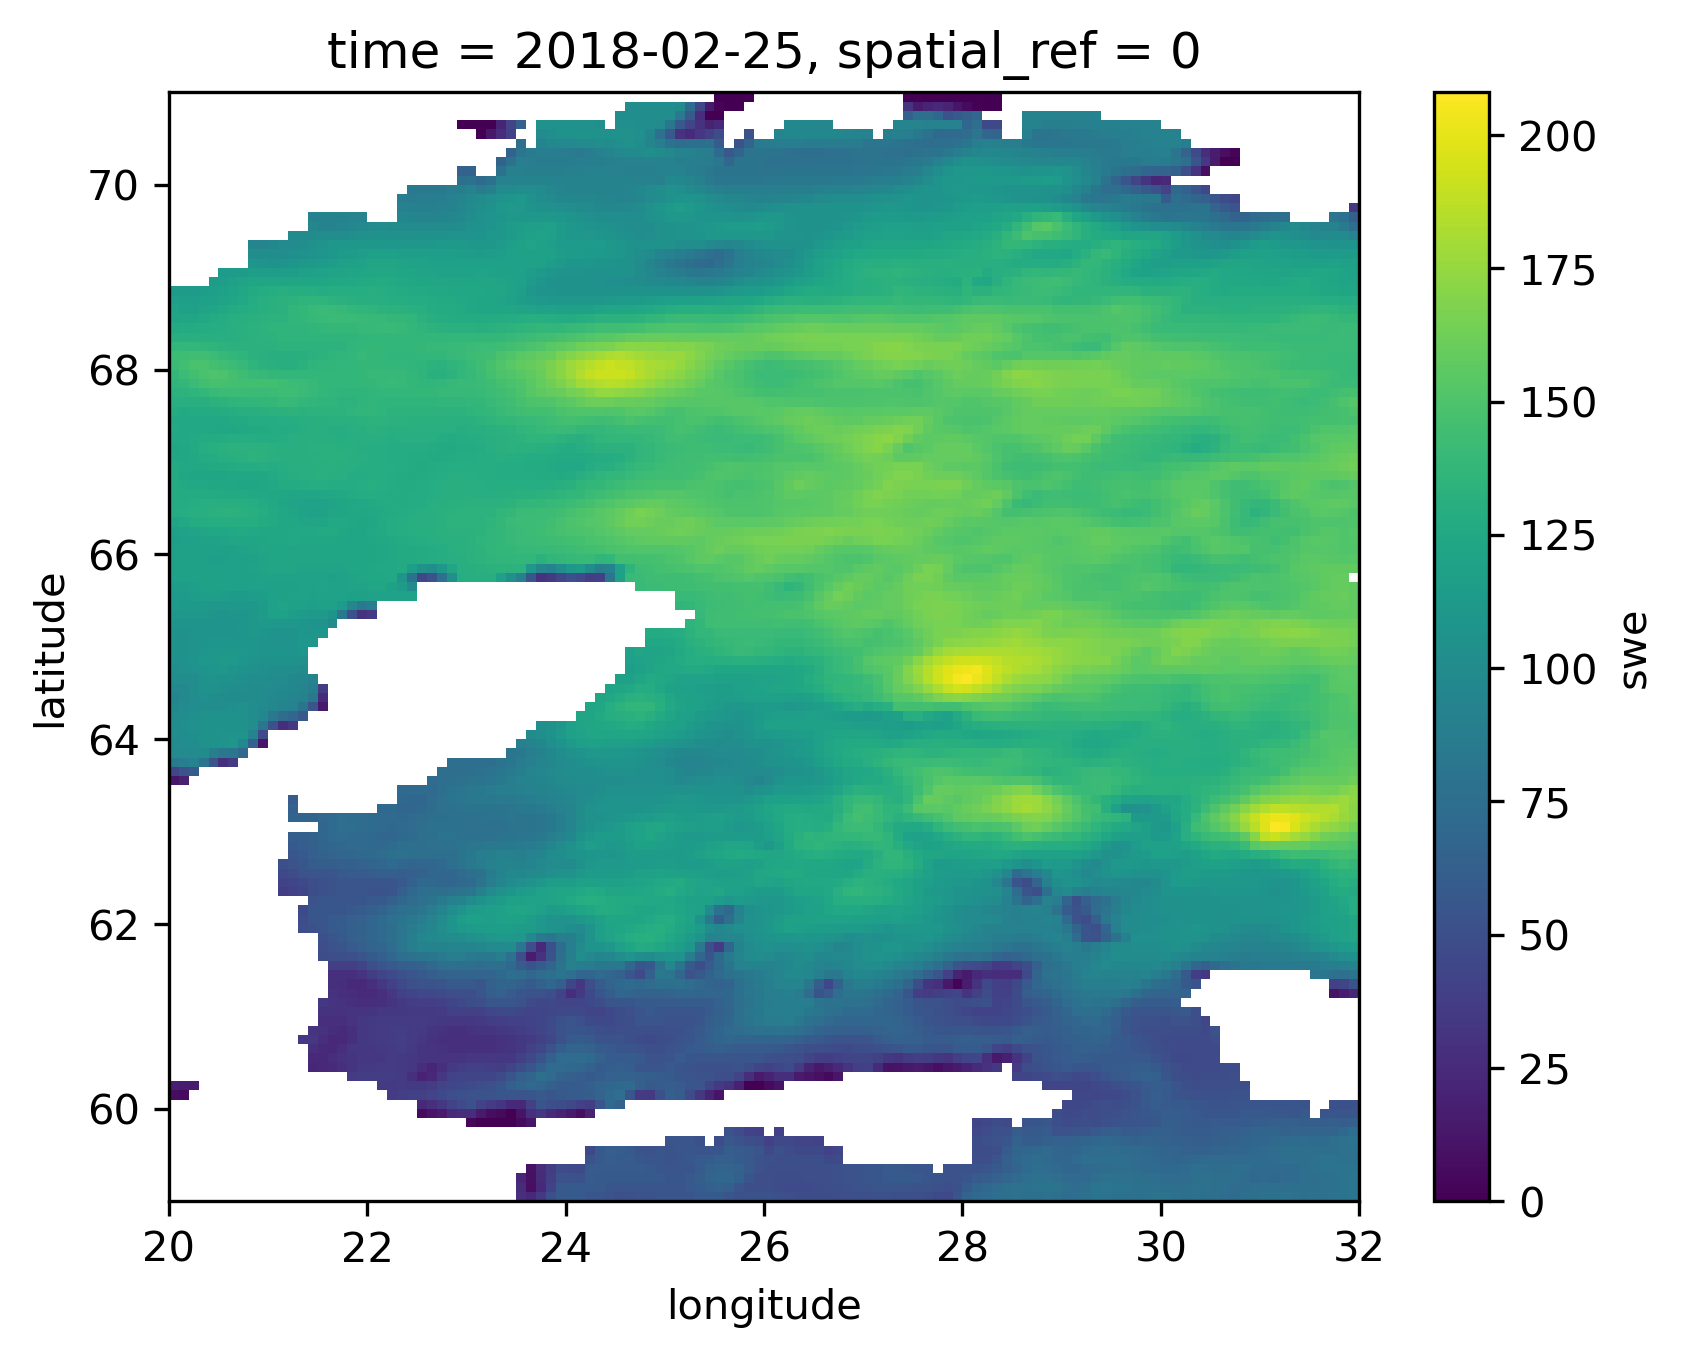

In [20]:
data_array.plot()

In [81]:
files[0:10]

['/media/iiro/T9/finland_climate/snow/data/swe/MERGED/v3.1/1979/01/19790102-ESACCI-L3C_SNOW-SWE-SMMR_NIMBUS7-fv3.1.nc',
 '/media/iiro/T9/finland_climate/snow/data/swe/MERGED/v3.1/1979/01/19790104-ESACCI-L3C_SNOW-SWE-SMMR_NIMBUS7-fv3.1.nc',
 '/media/iiro/T9/finland_climate/snow/data/swe/MERGED/v3.1/1979/01/19790106-ESACCI-L3C_SNOW-SWE-SMMR_NIMBUS7-fv3.1.nc',
 '/media/iiro/T9/finland_climate/snow/data/swe/MERGED/v3.1/1979/01/19790108-ESACCI-L3C_SNOW-SWE-SMMR_NIMBUS7-fv3.1.nc',
 '/media/iiro/T9/finland_climate/snow/data/swe/MERGED/v3.1/1979/01/19790110-ESACCI-L3C_SNOW-SWE-SMMR_NIMBUS7-fv3.1.nc',
 '/media/iiro/T9/finland_climate/snow/data/swe/MERGED/v3.1/1979/01/19790112-ESACCI-L3C_SNOW-SWE-SMMR_NIMBUS7-fv3.1.nc',
 '/media/iiro/T9/finland_climate/snow/data/swe/MERGED/v3.1/1979/01/19790114-ESACCI-L3C_SNOW-SWE-SMMR_NIMBUS7-fv3.1.nc',
 '/media/iiro/T9/finland_climate/snow/data/swe/MERGED/v3.1/1979/01/19790116-ESACCI-L3C_SNOW-SWE-SMMR_NIMBUS7-fv3.1.nc',
 '/media/iiro/T9/finland_climate/snow/da

In [24]:
xr.__version__

'2024.11.0'